In [92]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

In [114]:
df = pd.read_csv('cheque_product_data.csv')
df

,cheque_date,cheque_id,cheque_product_id,cheque_product_quantity,cheque_product_price,cheque_product_cost_per_unit
0,2024-01-19,e2ae5bc186a3ad9bd454927b59ce9f68,9,1.000,24,7.6
1,2024-01-19,fac587cfed841fb395b3128750d93b18,9,1.000,24,7.6
2,2024-01-19,fbd677861067904bd2a11d7c91c6f18a,9,1.000,24,7.6
3,2024-01-19,6a138657386ce61ca2c65d800fc17785,9,1.000,24,7.6
4,2024-01-19,7b92fbdf991ec8d5797b8eee631c3d90,9,1.000,24,7.6
...,...,...,...,...,...,...
3308031,2024-12-31,91ff1ac173d2c94c2b5c378d193c4496,8,1.084,52,18.0
3308032,2024-12-31,3cbfdb110c280041509c1c35ff9360ae,8,1.164,52,18.0
3308033,2024-12-31,530da036dc69b8c13c3cbc25c98b99fd,8,0.620,52,18.0
3308034,2024-12-31,3f43e1614534c6ce3c4d67951d7c1790,8,0.506,52,18.0


##### let's see whats is a number range of price changes

In [140]:
df_grouped = df.groupby(['cheque_product_id']).aggregate({'cheque_product_price': 'nunique'})
df_grouped.sort_values('cheque_product_price', ascending=False)

,cheque_product_price
cheque_product_id,
2235,63
35,48
87,48
103,47
2090,46
...,...
6,1
4,1
3,1


In [90]:
no_change_price_ids = df_grouped[df_grouped['cheque_product_price'] == 1].index
no_change_price_ids

Index([   1,    2,    3,    4,    6,   10,   11,   25,   42,   63,  213,  301,
        323,  383,  400,  495,  608,  668,  755,  818,  872,  933, 1063, 1595,
       1624, 1635, 1805, 1921, 1997, 2210, 2273],
      dtype='int64', name='cheque_product_id')

##### adding some additional info to the dataset

In [116]:
df["revenue"] = df["cheque_product_price"] * df["cheque_product_quantity"]
df["profit"] = df["revenue"] - df["cheque_product_cost_per_unit"] * df["cheque_product_quantity"]

df["margin_rate"] = (df["cheque_product_price"] - df["cheque_product_cost_per_unit"]) / df["cheque_product_price"]

df

,cheque_date,cheque_id,cheque_product_id,cheque_product_quantity,cheque_product_price,cheque_product_cost_per_unit,revenue,profit,margin_rate
0,2024-01-19,e2ae5bc186a3ad9bd454927b59ce9f68,9,1.000,24,7.6,24.000,16.400,0.683333
1,2024-01-19,fac587cfed841fb395b3128750d93b18,9,1.000,24,7.6,24.000,16.400,0.683333
2,2024-01-19,fbd677861067904bd2a11d7c91c6f18a,9,1.000,24,7.6,24.000,16.400,0.683333
3,2024-01-19,6a138657386ce61ca2c65d800fc17785,9,1.000,24,7.6,24.000,16.400,0.683333
4,2024-01-19,7b92fbdf991ec8d5797b8eee631c3d90,9,1.000,24,7.6,24.000,16.400,0.683333
...,...,...,...,...,...,...,...,...,...
3308031,2024-12-31,91ff1ac173d2c94c2b5c378d193c4496,8,1.084,52,18.0,56.368,36.856,0.653846
3308032,2024-12-31,3cbfdb110c280041509c1c35ff9360ae,8,1.164,52,18.0,60.528,39.576,0.653846
3308033,2024-12-31,530da036dc69b8c13c3cbc25c98b99fd,8,0.620,52,18.0,32.240,21.080,0.653846
3308034,2024-12-31,3f43e1614534c6ce3c4d67951d7c1790,8,0.506,52,18.0,26.312,17.204,0.653846


# Price Sensitivity Analysis + validation

#### Point Elasticity
$$
E = \frac{\%\ change\ in\ quantity}{\%\ change\ in\ price}
$$

Long story short, I aggregate transaction data weekly to reduce daily volatility and noise. This provides more stable patterns for elasticity calculation.
Instead of calculating elasticity between individual weeks, I group consecutive weeks with the same price into "price periods". This approach provides more stable quantity measurements and reduces the impact of transitional weeks. 

Calculation steps:

- Price change percentage:
$$
\%\Delta P = \frac{P_2 - P_1}{P_1} \times 100\
$$

- Quantity change percentage (using average weekly quantity):
$$
\%\Delta Q = \frac{Q_2 - Q_1}{Q_1} \times 100\
$$

- Point elasticity:
$$
E = \frac{\%\Delta Q}{\%\Delta P}
$$

After these operations, I decided to skip products with price_periods less than 2 weeks because short periods may not represent equilibrium demand. The number of price changes observed directly impacts our confidence in the elasticity estimates. Products with many price changes provide more data points, allowing us to average out temporary factors and obtain more reliable estimates. 

Products with elasticity below -2.0 are classified as highly elastic, indicating that customers are extremely price-sensitive and small price increases could lead to substantial volume losses. These products often face intense competition or have readily available substitutes. Products with elasticity between -2.0 and -1.0 are considered price elastic. While still price-sensitive, customer responses are more moderate than the highly elastic category. Unit elastic products, with elasticity between -1.0 and -0.5, show proportional responses where a 10% price increase leads to roughly a 5-10% quantity decrease. Finally, price inelastic products have an elasticity above -0.5, indicating that customers are relatively insensitive to price changes. These often include necessity items or products with strong brand loyalty.


On my first iterations, I faced some products with very high elasticities (hundreds or even thousands). As I understand it, the most common cause involves minimal price changes, often below 0.5%. The current solution involves implementing the minimum price change filter, typically set at 2-3% to ensure meaningful price variations. Using median instead of mean for aggregation helps reduce the impact of outliers.


In [ ]:
def classify_sensitivity(elasticity):
    if pd.isna(elasticity):
        return 'Unknown'
    elif elasticity > -0.5:
        return 'Price Inelastic'
    elif elasticity > -1.0:
        return 'Unit Elastic'
    elif elasticity > -2.0:
        return 'Price Elastic'
    else:
        return 'Highly Elastic'

here I am performing some simple calculation of the point elasticity for each product FOR EACH TIME PERIOD

In [155]:
df['week'] = pd.to_datetime(df['cheque_date']).dt.to_period('W')

weekly_agg = df.groupby(['cheque_product_id', 'week', 'cheque_product_price']).agg({
        'cheque_product_quantity': 'sum',
        'cheque_date': 'count'
    }).reset_index()

weekly_agg.columns = ['product_id', 'week', 'price', 'quantity', 'transaction_count']

In [156]:
weekly_agg

,product_id,week,price,quantity,transaction_count
0,1,2024-01-01/2024-01-07,0,168283.0,4206
1,1,2024-01-08/2024-01-14,0,186173.0,4588
2,1,2024-01-15/2024-01-21,0,200108.0,4772
3,1,2024-01-22/2024-01-28,0,181006.0,4414
4,1,2024-01-29/2024-02-04,0,184247.0,4537
...,...,...,...,...,...
167993,2999,2024-12-16/2024-12-22,76,2.0,2
167994,2999,2024-12-23/2024-12-29,42,7.0,3
167995,2999,2024-12-23/2024-12-29,60,1.0,1
167996,2999,2024-12-30/2025-01-05,42,1.0,1


In [179]:
min_price_change_pct=1.0
elasticity_bounds=(-20, 20)

In [ ]:
elasticity_results = []

for product_id in weekly_agg['product_id'].unique():
    product_data = weekly_agg[weekly_agg['product_id'] == product_id].sort_values('week')
    
    price_periods = []
    current_price = None
    start_week = None
    
    for _, row in product_data.iterrows():
        if current_price != row['price']:
            if current_price is not None:
                price_periods.append({
                    'price': current_price,
                    'start_week': start_week,
                    'end_week': prev_week,
                    'total_quantity': period_quantity,
                    'avg_weekly_quantity': period_quantity / week_count,
                    'transaction_count': period_transactions,
                    'week_count': week_count
                })
            current_price = row['price']
            start_week = row['week']
            period_quantity = row['quantity']
            period_transactions = row['transaction_count']
            week_count = 1
        else:
            period_quantity += row['quantity']
            period_transactions += row['transaction_count']
            week_count += 1
        prev_week = row['week']
    
    if current_price is not None:
        price_periods.append({
            'price': current_price,
            'start_week': start_week,
            'end_week': prev_week,
            'total_quantity': period_quantity,
            'avg_weekly_quantity': period_quantity / week_count,
            'transaction_count': period_transactions,
            'week_count': week_count
        })
    
    if len(price_periods) >= 2:
        for i in range(1, len(price_periods)):
            prev_period = price_periods[i-1]
            curr_period = price_periods[i]
            
            price_change_pct = ((curr_period['price'] - prev_period['price']) / prev_period['price']) * 100
            
            if abs(price_change_pct) < min_price_change_pct:
                continue
            
            if prev_period['week_count'] < 2 or curr_period['week_count'] < 2:
                continue

            quantity_change_pct = ((curr_period['avg_weekly_quantity'] - prev_period['avg_weekly_quantity']) / 
                                    prev_period['avg_weekly_quantity']) * 100
            
            point_elasticity = quantity_change_pct / price_change_pct
            
            elasticity_capped = np.clip(point_elasticity, elasticity_bounds[0], elasticity_bounds[1])
            is_capped = (point_elasticity != elasticity_capped)
            
            elasticity_results.append({
                'product_id': product_id,
                'price_change_num': i,
                'price_from': prev_period['price'],
                'price_to': curr_period['price'],
                'price_change_pct': price_change_pct,
                'quantity_from': prev_period['avg_weekly_quantity'],
                'quantity_to': curr_period['avg_weekly_quantity'],
                'quantity_change_pct': quantity_change_pct,
                'point_elasticity': point_elasticity,
                'elasticity_capped': elasticity_capped,
                'is_outlier': is_capped,
                'period_from': f"{prev_period['start_week']} to {prev_period['end_week']}",
                'period_to': f"{curr_period['start_week']} to {curr_period['end_week']}",
                'weeks_from': prev_period['week_count'],
                'weeks_to': curr_period['week_count'],
                'transactions_from': prev_period['transaction_count'],
                'transactions_to': curr_period['transaction_count']
            })


In [181]:
elasticity_df = pd.DataFrame(elasticity_results)
elasticity_df

,product_id,price_change_num,price_from,price_to,price_change_pct,quantity_from,quantity_to,quantity_change_pct,point_elasticity,elasticity_capped,is_outlier,period_from,period_to,weeks_from,weeks_to,transactions_from,transactions_to
0,5,1,4,3,-25.000000,5800.000000,4926.666667,-15.057471,0.602299,0.602299,False,2024-01-01/2024-01-07 to 2024-01-22/2024-01-28,2024-01-29/2024-02-04 to 2024-02-12/2024-02-18,4,3,1733,1028
1,5,7,2,3,50.000000,7166.000000,8274.833333,15.473532,0.309471,0.309471,False,2024-03-04/2024-03-10 to 2024-04-08/2024-04-14,2024-04-08/2024-04-14 to 2024-05-13/2024-05-19,6,6,2495,3009
2,5,8,3,4,33.333333,8274.833333,2804.000000,-66.114121,-1.983424,-1.983424,False,2024-04-08/2024-04-14 to 2024-05-13/2024-05-19,2024-05-13/2024-05-19 to 2024-05-20/2024-05-26,6,2,3009,383
3,5,19,2,3,50.000000,5033.000000,4033.777778,-19.853412,-0.397068,-0.397068,False,2024-07-15/2024-07-21 to 2024-07-29/2024-08-04,2024-07-29/2024-08-04 to 2024-09-23/2024-09-29,3,9,993,2532
4,5,20,3,4,33.333333,4033.777778,3654.400000,-9.405024,-0.282151,-0.282151,False,2024-07-29/2024-08-04 to 2024-09-23/2024-09-29,2024-09-23/2024-09-29 to 2024-10-21/2024-10-27,9,5,2532,1295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3690,2947,10,275,195,-29.090909,0.827500,18.091000,2086.223565,-71.713935,-20.000000,True,2024-07-01/2024-07-07 to 2024-07-22/2024-07-28,2024-07-29/2024-08-04 to 2024-08-05/2024-08-11,4,2,16,118
3691,2995,5,255,270,5.882353,1.615000,2.348000,45.386997,7.715789,7.715789,False,2024-05-27/2024-06-02 to 2024-06-03/2024-06-09,2024-06-03/2024-06-09 to 2024-06-10/2024-06-16,2,2,14,19
3692,2995,19,230,255,10.869565,15.103333,5.006000,-66.854999,-6.150660,-6.150660,False,2024-08-12/2024-08-18 to 2024-08-26/2024-09-01,2024-08-26/2024-09-01 to 2024-09-02/2024-09-08,3,2,156,39
3693,2995,23,240,245,2.083333,11.354000,1.042000,-90.822618,-43.594856,-20.000000,True,2024-09-16/2024-09-22 to 2024-09-30/2024-10-06,2024-09-30/2024-10-06 to 2024-10-07/2024-10-13,3,2,135,10


##### Average elasticity per product calculation

In [ ]:
product_elasticity = elasticity_df.groupby('product_id').agg({
    'elasticity_capped': ['mean', 'median', 'std', 'count'],
    'price_change_pct': 'count',
    'is_outlier': 'sum'
}).reset_index()

product_elasticity.columns = ['product_id', 'avg_elasticity', 'median_elasticity', 
                                'elasticity_std', 'elasticity_count', 
                                'num_price_changes', 'num_outliers']

product_elasticity['confidence_level'] = product_elasticity['elasticity_count'].apply(
    lambda x: 'High' if x >= 10 else ('Medium' if x >= 5 else 'Low')
)

product_elasticity['price_sensitivity'] = product_elasticity['avg_elasticity'].apply(
    lambda x: classify_sensitivity(x)
)

product_elasticity['outlier_pct'] = (product_elasticity['num_outliers'] / 
                                    product_elasticity['num_price_changes'] * 100).round(1)

In [186]:
print("Product Elasticity Summary:")
product_elasticity

Product Elasticity Summary:


,product_id,avg_elasticity,median_elasticity,elasticity_std,elasticity_count,num_price_changes,num_outliers,confidence_level,price_sensitivity,outlier_pct
0,5,0.276331,-0.105243,1.415994,9,9,0,Medium,Price Inelastic,0.0
1,12,-0.886207,-0.886207,NaN,1,1,0,Low,Unit Elastic,0.0
2,15,-1.965252,-1.965252,NaN,1,1,0,Low,Price Elastic,0.0
3,17,0.630174,0.630174,0.556230,2,2,0,Low,Price Inelastic,0.0
4,18,5.955567,5.955567,NaN,1,1,0,Low,Price Inelastic,0.0
...,...,...,...,...,...,...,...,...,...,...
968,2909,7.636416,7.636416,13.776620,2,2,0,Low,Price Inelastic,0.0
969,2945,-6.111235,-6.111235,4.473099,2,2,0,Low,Highly Elastic,0.0
970,2947,-10.869196,-10.780100,8.677735,8,8,3,Medium,Highly Elastic,37.5
971,2995,-6.144957,-6.150660,13.857896,3,3,1,Low,Highly Elastic,33.3


In [187]:
product_elasticity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   product_id         973 non-null    int64  
 1   avg_elasticity     973 non-null    float64
 2   median_elasticity  973 non-null    float64
 3   elasticity_std     767 non-null    float64
 4   elasticity_count   973 non-null    int64  
 5   num_price_changes  973 non-null    int64  
 6   num_outliers       973 non-null    int64  
 7   confidence_level   973 non-null    object 
 8   price_sensitivity  973 non-null    object 
 9   outlier_pct        973 non-null    float64
dtypes: float64(4), int64(4), object(2)
memory usage: 76.1+ KB


In [203]:
sensitive_product_ids = product_elasticity[product_elasticity['price_sensitivity'] == 'Highly Elastic']['product_id']
sensitive_product_ids_high_confidence = product_elasticity[(product_elasticity['price_sensitivity'] == 'Highly Elastic') & 
                                                           (product_elasticity['confidence_level'] == 'High')]['product_id']
# sensitive_product_ids
sensitive_product_ids_high_confidence

126     242
236     392
249     417
259     431
304     500
309     505
350     562
437     701
463     750
471     763
474     769
475     770
484     785
485     786
497     800
500     804
510     824
574     943
640    1093
645    1107
651    1118
704    1242
708    1254
722    1294
768    1455
793    1571
810    1641
967    2891
Name: product_id, dtype: int64

In [204]:
sensitive_products = df[df['cheque_product_id'].isin(sensitive_product_ids)]
sensitive_products_high_confidence = df[df['cheque_product_id'].isin(sensitive_product_ids_high_confidence)]

overall high sensivity


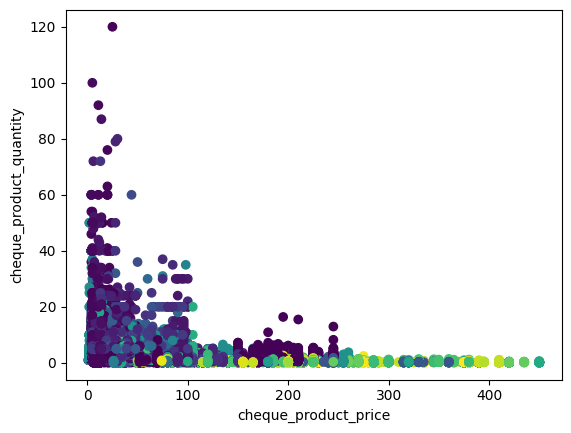

high confidence high sensitivity


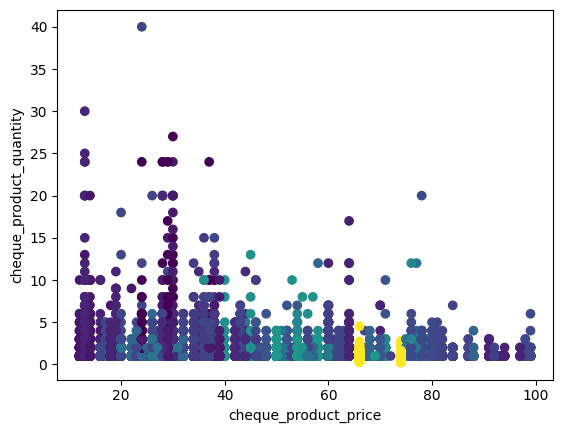

In [206]:
import matplotlib.pyplot as plt

print("overall high sensivity")
plt.scatter(sensitive_products['cheque_product_price'], sensitive_products['cheque_product_quantity'], c=sensitive_products['cheque_product_id'], cmap='viridis')
plt.xlabel('cheque_product_price')
plt.ylabel('cheque_product_quantity')
plt.show()

print("high confidence high sensitivity")
plt.scatter(sensitive_products_high_confidence['cheque_product_price'], sensitive_products_high_confidence['cheque_product_quantity'], c=sensitive_products_high_confidence['cheque_product_id'], cmap='viridis')
plt.xlabel('cheque_product_price')
plt.ylabel('cheque_product_quantity')
plt.show()

#### Here is some interesting stuff with plots

In [199]:
print("Distribution of price changes:")

price_changes = elasticity_df['price_change_pct'].abs()

print(f"Minimum price change: {price_changes.min():.4f}%")
print(f"Price changes < 1%: {(price_changes < 1).sum()} ({(price_changes < 1).mean()*100:.1f}%)")
print(f"Price changes < 0.5%: {(price_changes < 0.5).sum()} ({(price_changes < 0.5).mean()*100:.1f}%)")
print("Price change percentiles:")


price_changes.describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])


Distribution of price changes:
Minimum price change: 1.0101%
Price changes < 1%: 0 (0.0%)
Price changes < 0.5%: 0 (0.0%)
Price change percentiles:


count    3695.000000
mean       22.183562
std        27.554836
min         1.010101
1%          1.612903
5%          2.222222
10%         2.941176
25%         6.250000
50%        19.047619
75%        31.530214
90%        43.333333
95%        53.571429
99%        75.000000
max       781.818182
Name: price_change_pct, dtype: float64

In [200]:

print("Extreme elasticity cases (top 10):")
extreme_cases = elasticity_df.nlargest(10, 'point_elasticity')[
    ['product_id', 'price_from', 'price_to', 'price_change_pct', 
     'quantity_from', 'quantity_to', 'quantity_change_pct', 'point_elasticity']
]
extreme_cases



Extreme elasticity cases (top 10):


,product_id,price_from,price_to,price_change_pct,quantity_from,quantity_to,quantity_change_pct,point_elasticity
589,288,75,76,1.333333,17.384615,114.500000,558.628319,418.971239
2088,873,19,20,5.263158,1.500000,17.400000,1060.000000,201.400000
28,44,35,37,5.714286,14.500000,160.500000,1006.896552,176.206897
159,126,61,62,1.639344,16.333333,58.000000,255.102041,155.612245
210,141,13,14,7.692308,3.500000,45.333333,1195.238095,155.380952
2354,1004,38,39,2.631579,2.500000,9.888889,295.555556,112.311111
29,44,44,45,2.272727,42.000000,149.000000,254.761905,112.095238
2431,1061,22,24,9.090909,6.000000,67.000000,1016.666667,111.833333
1187,530,26,27,3.846154,3.500000,18.500000,428.571429,111.428571
2967,1418,66,67,1.515152,2.000000,5.333333,166.666667,110.000000


Analysis for products with high average elasticity:
  Product 7:
  Number of price changes: 0
  Elasticity range: [nan, nan]
  Price change range: [nan%, nan%]
  Small price changes (<1%): 0
  Product 8:
  Number of price changes: 0
  Elasticity range: [nan, nan]
  Price change range: [nan%, nan%]
  Small price changes (<1%): 0


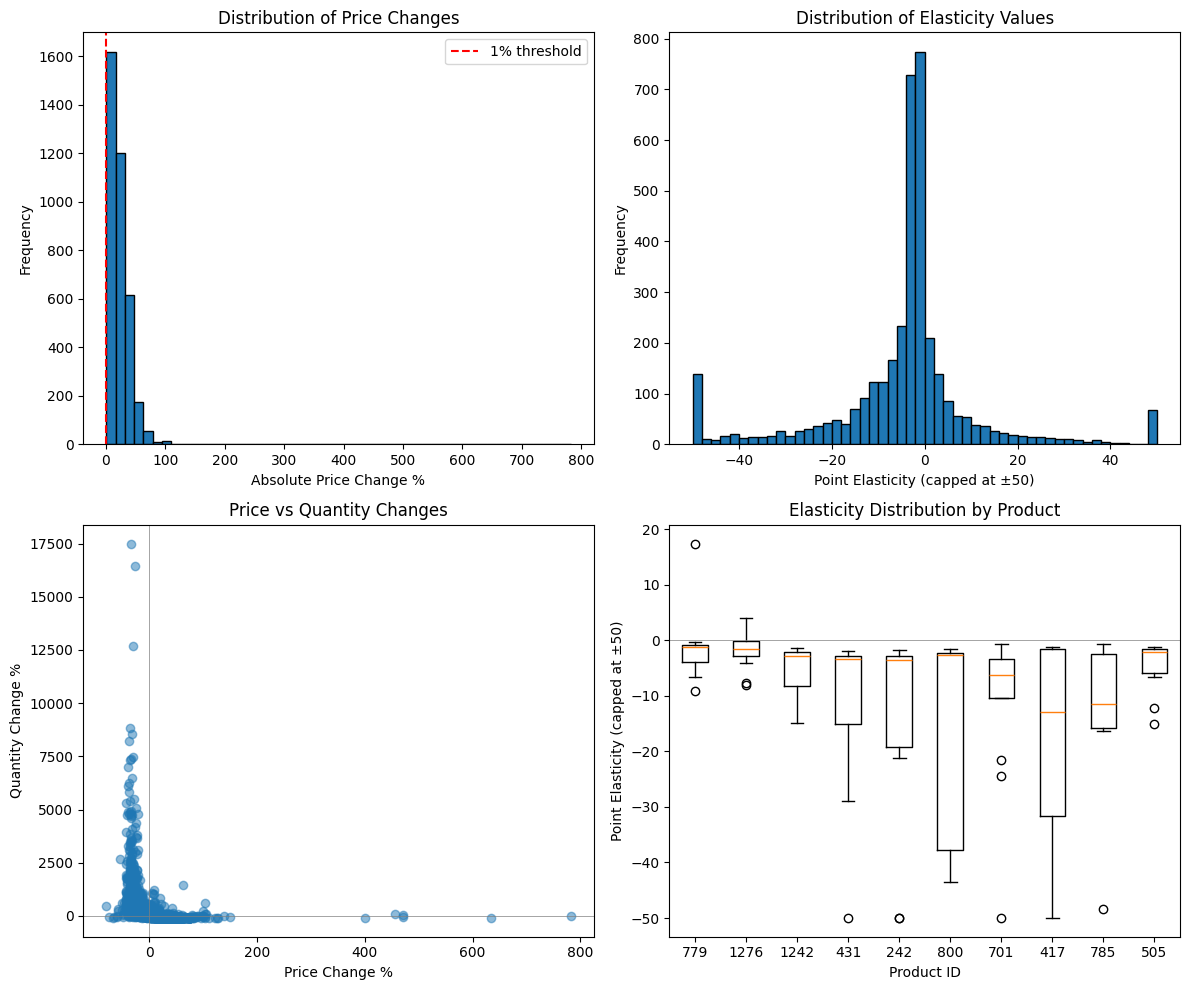

In [201]:
print("Analysis for products with high average elasticity:")
for product_id in [7, 8]:
    product_data = elasticity_df[elasticity_df['product_id'] == product_id]
    print(f"  Product {product_id}:")
    print(f"  Number of price changes: {len(product_data)}")
    print(f"  Elasticity range: [{product_data['point_elasticity'].min():.2f}, {product_data['point_elasticity'].max():.2f}]")
    print(f"  Price change range: [{product_data['price_change_pct'].min():.2f}%, {product_data['price_change_pct'].max():.2f}%]")
    print(f"  Small price changes (<1%): {(product_data['price_change_pct'].abs() < 1).sum()}")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].hist(elasticity_df['price_change_pct'].abs(), bins=50, edgecolor='black')
axes[0, 0].set_xlabel('Absolute Price Change %')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Price Changes')
axes[0, 0].axvline(x=1, color='red', linestyle='--', label='1% threshold')
axes[0, 0].legend()

elasticity_capped_viz = elasticity_df['point_elasticity'].clip(-50, 50)
axes[0, 1].hist(elasticity_capped_viz, bins=50, edgecolor='black')
axes[0, 1].set_xlabel('Point Elasticity (capped at ±50)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Elasticity Values')

axes[1, 0].scatter(elasticity_df['price_change_pct'], 
                   elasticity_df['quantity_change_pct'], 
                   alpha=0.5)
axes[1, 0].set_xlabel('Price Change %')
axes[1, 0].set_ylabel('Quantity Change %')
axes[1, 0].set_title('Price vs Quantity Changes')
axes[1, 0].axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
axes[1, 0].axvline(x=0, color='gray', linestyle='-', linewidth=0.5)

top_products = elasticity_df['product_id'].value_counts().head(10).index
data_for_box = [elasticity_df[elasticity_df['product_id'] == pid]['point_elasticity'].clip(-50, 50) 
                for pid in top_products]
axes[1, 1].boxplot(data_for_box, labels=top_products)
axes[1, 1].set_xlabel('Product ID')
axes[1, 1].set_ylabel('Point Elasticity (capped at ±50)')
axes[1, 1].set_title('Elasticity Distribution by Product')
axes[1, 1].axhline(y=0, color='gray', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

In [211]:
sensitive_products_high_confidence["revenue"] = sensitive_products_high_confidence["cheque_product_price"] * sensitive_products_high_confidence["cheque_product_quantity"]
sensitive_products_high_confidence["profit"] = sensitive_products_high_confidence["revenue"] - sensitive_products_high_confidence.cheque_product_cost_per_unit

sensitive_products_high_confidence.head()

,cheque_date,cheque_id,cheque_product_id,cheque_product_quantity,cheque_product_price,cheque_product_cost_per_unit,revenue,profit,margin_rate,week,date,period,year,month,week_of_year,day_of_week,is_weekend
24708,2024-04-01,5b6fdfe150155e730873d073cb2fa327,1107,1.0,24,10.2,24.0,13.8,0.575,2024-04-01/2024-04-07,2024-04-01,2024-04-01/2024-04-07,2024,4,14,0,0
24709,2024-04-02,7619c020fd60403354dafe6002576c81,1107,1.0,24,10.2,24.0,13.8,0.575,2024-04-01/2024-04-07,2024-04-02,2024-04-01/2024-04-07,2024,4,14,1,0
24710,2024-04-03,5e5f7f14214a22438452d6c50f2bf49a,1107,1.0,24,10.2,24.0,13.8,0.575,2024-04-01/2024-04-07,2024-04-03,2024-04-01/2024-04-07,2024,4,14,2,0
24711,2024-04-03,410e9aa1a62dee5657ca34efb8329e49,1107,1.0,24,10.2,24.0,13.8,0.575,2024-04-01/2024-04-07,2024-04-03,2024-04-01/2024-04-07,2024,4,14,2,0
24712,2024-04-03,0d52fc387945648b5778aebde985c8ac,1107,1.0,24,10.2,24.0,13.8,0.575,2024-04-01/2024-04-07,2024-04-03,2024-04-01/2024-04-07,2024,4,14,2,0


# KPI analysis

1. Product Metrics Aggregation\
   ↓
2. Derived Metrics Calculation\
   ↓
3. Elasticity Integration\
   ↓
4. Promotion Scoring\
   ↓
5. Business Impact Classification\
   ↓
6. Product Type Categorization\
   ↓
7. Final Ranking


The process overall is above, let's dive into some details.

`sensitive_products_high_confidence`: transaction data containing only products with high price sensitivity and statistical confidence. Products with low elasticity (|E| < 0.5) show minimal response to price changes, making promotions ineffective. By starting with sensitive products, we ensure every analyzed product has proven price responsiveness.

Metrics:
- Profit Margin
- Days Active
- Daily Revenue (normalized)
- Revenue Share 
- Quantity Variability (cv)
- Price Stability 

In [255]:
results = {}

In [ ]:
product_metrics = sensitive_products_high_confidence.groupby('cheque_product_id').agg({
        'revenue': ['sum', 'mean', 'std'],
        'cheque_product_quantity': ['sum', 'mean', 'std'],
        'profit': 'sum',
        'cheque_id': 'count',
        'date': ['min', 'max'],
        'cheque_product_price': ['mean', 'std']
    }).round(2)

# product_metrics.columns = ['revenue', 'quantity', 'profit', 'cheque_id', 'date', 'price']
product_metrics.columns = ['_'.join(col).strip() for col in product_metrics.columns.values]
product_metrics = product_metrics.reset_index()

product_metrics.columns = [col.replace('cheque_', '') for col in product_metrics.columns]

product_metrics.head()

,product_id,revenue_sum,revenue_mean,revenue_std,product_quantity_sum,product_quantity_mean,product_quantity_std,profit_sum,id_count,date_min,date_max,product_price_mean,product_price_std
0,242,82157.0,64.54,67.71,2809.0,2.21,2.27,66244.5,1273,2024-01-01,2024-12-28,29.37,3.59
1,392,26933.0,19.09,14.18,1931.0,1.37,1.05,18325.9,1411,2024-01-02,2024-12-31,14.11,2.04
2,417,28934.0,24.73,16.82,1867.0,1.60,1.15,19691.0,1170,2024-01-04,2024-12-27,15.96,3.84
3,431,52157.0,62.99,70.74,1722.0,2.08,2.33,44042.6,828,2024-01-01,2024-12-30,30.33,2.97
4,500,100195.0,99.40,79.58,1567.0,1.55,1.25,69148.6,1008,2024-01-04,2024-12-29,64.21,8.50


In [ ]:
product_metrics['profit_margin'] = (
    product_metrics['profit_sum'] / product_metrics['revenue_sum']
).fillna(0)

product_metrics['days_active'] = (product_metrics['date_max'] - product_metrics['date_min']).dt.days + 1
product_metrics['daily_revenue'] = product_metrics['revenue_sum'] / product_metrics['days_active']
product_metrics['revenue_share'] = product_metrics['revenue_sum'] / product_metrics['revenue_sum'].sum()
product_metrics['quantity_cv'] = (product_metrics['product_quantity_std'] / product_metrics['product_quantity_mean']).fillna(0)
product_metrics['price_stability'] = 1 / (1 + product_metrics['product_price_std'])

In [258]:
kpi_df = product_metrics.merge(
            product_elasticity[['product_id', 'avg_elasticity', 'elasticity_std', 
                               'elasticity_count', 'confidence_level']],
            on='product_id',
            how='inner'
        )

results['kpi_df'] = kpi_df

kpi_df.head()

,product_id,revenue_sum,revenue_mean,revenue_std,product_quantity_sum,product_quantity_mean,product_quantity_std,profit_sum,id_count,date_min,...,profit_margin,days_active,daily_revenue,revenue_share,quantity_cv,price_stability,avg_elasticity,elasticity_std,elasticity_count,confidence_level
0,242,82157.0,64.54,67.71,2809.0,2.21,2.27,66244.5,1273,2024-01-01,...,0.806316,363,226.327824,0.069751,1.027149,0.217865,-8.795011,7.972558,13,High
1,392,26933.0,19.09,14.18,1931.0,1.37,1.05,18325.9,1411,2024-01-02,...,0.680426,365,73.789041,0.022866,0.766423,0.328947,-10.369318,9.235628,11,High
2,417,28934.0,24.73,16.82,1867.0,1.60,1.15,19691.0,1170,2024-01-04,...,0.680549,359,80.596100,0.024565,0.718750,0.206612,-10.842437,8.729069,12,High
3,431,52157.0,62.99,70.74,1722.0,2.08,2.33,44042.6,828,2024-01-01,...,0.844424,365,142.895890,0.044281,1.120192,0.251889,-8.421000,7.122819,13,High
4,500,100195.0,99.40,79.58,1567.0,1.55,1.25,69148.6,1008,2024-01-04,...,0.690140,361,277.548476,0.085065,0.806452,0.105263,-10.069120,9.508915,11,High


In [ ]:
from sklearn.preprocessing import MinMaxScaler

kpi_df['elasticity_score'] = kpi_df['avg_elasticity'].abs()
kpi_df['revenue_impact_score'] = kpi_df['revenue_share'] * 100
kpi_df['margin_flexibility_score'] = kpi_df['profit_margin'] * 100
kpi_df['consistency_score'] = 1 / (1 + kpi_df['elasticity_std'])
kpi_df['stability_score'] = kpi_df['price_stability']

score_columns = ['elasticity_score', 'revenue_impact_score', 
                'margin_flexibility_score', 'consistency_score', 'stability_score']

scaler = MinMaxScaler(feature_range=(0, 100))
kpi_df[score_columns] = scaler.fit_transform(kpi_df[score_columns])

confidence_map = {'High': 1.0, 'Medium': 0.8, 'Low': 0.6}
kpi_df['confidence_multiplier'] = kpi_df['confidence_level'].map(confidence_map)

weights = {
    'elasticity_score': 0.30,
    'revenue_impact_score': 0.25,
    'margin_flexibility_score': 0.20,
    'consistency_score': 0.15,
    'stability_score': 0.10
}

# why these values? check bellow


kpi_df['promotion_potential_score'] = (
    sum(kpi_df[col] * weight for col, weight in weights.items()) * 
    kpi_df['confidence_multiplier']
).round(2)

results['scored_df'] = kpi_df

Elasticity Score:        30%\
Revenue Impact Score:    25%\
Margin Flexibility:      20%\
Consistency Score:       15%\
Stability Score:         10%\
Total:                  100%


This distribution was suggested (not by me) as "classic one", so here is an explanation:

1. Elasticity Score (30%) - Highest Weight\
Why 30%?

Primary Success Driver: Elasticity directly predicts volume response to price changes. Without sufficient elasticity, promotions simply reduce margins without driving incremental volume.
Proven Metric: Unlike other scores, elasticity is based on actual customer behavior, not business metrics.
Direct ROI Impact: A product with -2.0 elasticity will generate 20% volume lift from a 10% discount, while -0.5 elasticity yields only 5% lift.
Business Logic: If customers don't respond to price changes, no amount of margin or revenue importance can make a promotion successful. This is why elasticity gets the highest weight.

2. Revenue Impact Score (25%) - Second Highest\
Why 25%?

Business Materiality: Promoting high-revenue products has greater absolute impact on business performance.
Risk Mitigation: Focusing on proven revenue generators reduces the risk of promoting unimportant products.
Scale Benefits: Fixed promotion costs (advertising, setup) are better amortized across high-revenue products.

Example Impact:
10% lift on a product with 5% revenue share = 0.5% total revenue increase
10% lift on a product with 0.1% revenue share = 0.01% total revenue increase

3. Margin Flexibility Score (20%) - Profitability Protection\
Why 20%?

Sustainability Check: Ensures promotions don't erode profitability.
Discount Depth Enabler: Higher margins allow deeper discounts for greater customer impact.
Not Primary: While important, margin alone doesn't drive promotion success - customer response does.

Practical Example:
30% margin product can offer 15% discount and maintain 15% margin
15% margin product with same discount operates at breakeven

4. Consistency Score (15%) - Predictability Factor\
Why 15%?

Risk Reduction: Products with consistent elasticity patterns are more predictable.
Planning Confidence: Lower variance means more accurate volume forecasts.
Secondary Importance: Consistency matters, but a highly elastic product with some variance is still better than a consistently inelastic one.

Business Impact:
High consistency (low elasticity_std) means promotion results are repeatable, reducing planning risk.

5. Stability Score (10%) - Market Maturity Indicator\
Why 10%?

Supporting Metric: Price stability indicates established market position but doesn't directly drive promotion success.
Quality Signal: Stable prices suggest mature products with established customer expectations.
Lowest Priority: A product with unstable prices but high elasticity can still be a good promotion candidate.


In [252]:
kpi_df.head(2)

,product_id,revenue_sum,revenue_mean,revenue_std,product_quantity_sum,product_quantity_mean,product_quantity_std,profit_sum,id_count,date_min,...,elasticity_std,elasticity_count,confidence_level,elasticity_score,revenue_impact_score,margin_flexibility_score,consistency_score,stability_score,confidence_multiplier,promotion_potential_score
0,242,82157.0,64.54,67.71,2809.0,2.21,2.27,66244.5,1273,2024-01-01,...,7.972558,13,High,66.894609,78.356651,77.775694,34.131310,56.527917,1.0,65.99
1,392,26933.0,19.09,14.18,1931.0,1.37,1.05,18325.9,1411,2024-01-02,...,9.235628,11,High,83.397987,12.094742,35.624656,22.471354,100.000000,1.0,48.54


In [ ]:
df_business_impact = kpi_df.copy()
        
elasticity_threshold = df_business_impact['avg_elasticity'].abs().median()
margin_threshold = df_business_impact['profit_margin'].median()
revenue_threshold = df_business_impact['revenue_share'].median()

conditions = [
    (df_business_impact['avg_elasticity'].abs() > elasticity_threshold) & 
    (df_business_impact['profit_margin'] > margin_threshold) & 
    (df_business_impact['revenue_share'] > revenue_threshold * 0.5),
    (df_business_impact['avg_elasticity'].abs() > elasticity_threshold * 1.5) & 
    (df_business_impact['profit_margin'] < margin_threshold * 0.5),
    (df_business_impact['avg_elasticity'].abs() > elasticity_threshold * 0.7) & 
    (df_business_impact['revenue_share'] > revenue_threshold * 2)
]

choices = ['Positive Impact', 'Negative Impact', 'Positive Impact']
df_business_impact['business_impact_category'] = np.select(conditions, choices, default='Mixed Impact')
results['impact_df'] = df_business_impact


In [254]:
df_business_impact.head(5)

,product_id,revenue_sum,revenue_mean,revenue_std,product_quantity_sum,product_quantity_mean,product_quantity_std,profit_sum,id_count,date_min,...,elasticity_count,confidence_level,elasticity_score,revenue_impact_score,margin_flexibility_score,consistency_score,stability_score,confidence_multiplier,promotion_potential_score,business_impact_category
0,242,82157.0,64.54,67.71,2809.0,2.21,2.27,66244.5,1273,2024-01-01,...,13,High,66.894609,78.356651,77.775694,34.131310,56.527917,1.0,65.99,Positive Impact
1,392,26933.0,19.09,14.18,1931.0,1.37,1.05,18325.9,1411,2024-01-02,...,11,High,83.397987,12.094742,35.624656,22.471354,100.000000,1.0,48.54,Mixed Impact
2,417,28934.0,24.73,16.82,1867.0,1.60,1.15,19691.0,1170,2024-01-04,...,12,High,88.357663,14.495692,35.665951,26.784005,52.123920,1.0,46.49,Mixed Impact
3,431,52157.0,62.99,70.74,1722.0,2.08,2.33,44042.6,828,2024-01-01,...,13,High,62.973872,42.360395,90.535004,44.015988,69.843295,1.0,61.18,Positive Impact
4,500,100195.0,99.40,79.58,1567.0,1.55,1.25,69148.6,1008,2024-01-04,...,11,High,80.251026,100.000000,38.877371,20.317348,12.461248,1.0,61.14,Positive Impact


In [261]:
quantity_analysis = sensitive_products_high_confidence.groupby('cheque_product_id')['cheque_product_quantity'].agg([
    'count',
    'mean',
    'std',
    lambda x: (x % 1 != 0).mean(),  
    lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else x.mean() 
]).round(4)

quantity_analysis.head(2)

,count,mean,std,<lambda_0>,<lambda_1>
cheque_product_id,,,,,
242,1273,2.2066,2.2735,0.0,1.0
392,1411,1.3685,1.0520,0.0,1.0


In [ ]:

quantity_analysis.columns = ['transaction_count', 'avg_quantity', 'std_quantity', 
                            'decimal_pct', 'mode_quantity']

quantity_analysis['quantity_cv'] = (quantity_analysis['std_quantity'] / quantity_analysis['avg_quantity']).fillna(0)
quantity_analysis['is_weighted'] = (
    (quantity_analysis['decimal_pct'] > 0.3) | (quantity_analysis['quantity_cv'] > 1.5) |  (quantity_analysis['mode_quantity'] % 1 != 0)  
)

quantity_analysis['classification_reason'] = np.where(
    quantity_analysis['decimal_pct'] > 0.3,
    'High decimal quantities',
    np.where(
        quantity_analysis['quantity_cv'] > 1.5,
        'High quantity variation',
        np.where(
            quantity_analysis['mode_quantity'] % 1 != 0,
            'Decimal mode quantity',
            'Integer quantities'
        )
    )
)

results['impact_df'] = results['impact_df'].merge(
    quantity_analysis[['is_weighted', 'classification_reason']],
    left_on='product_id',
    right_index=True
)

In [264]:
quantity_analysis.head(2)

,transaction_count,avg_quantity,std_quantity,decimal_pct,mode_quantity,quantity_cv,is_weighted,classification_reason
cheque_product_id,,,,,,,,
242,1273,2.2066,2.2735,0.0,1.0,1.030318,False,Integer quantities
392,1411,1.3685,1.0520,0.0,1.0,0.768725,False,Integer quantities


In [263]:
results['quantity_analysis'] = quantity_analysis

In [ ]:
df_category = results['impact_df'].copy()
        
weighted_df = df_category[df_category['is_weighted']].copy()
weighted_df['category_rank'] = weighted_df['promotion_potential_score'].rank(ascending=False, method='min').astype(int)
weighted_df['percentile_rank'] = weighted_df['promotion_potential_score'].rank(pct=True).round(3)


non_weighted_df = df_category[~df_category['is_weighted']].copy()
non_weighted_df['category_rank'] = non_weighted_df['promotion_potential_score'].rank(ascending=False, method='min').astype(int)
non_weighted_df['percentile_rank'] = non_weighted_df['promotion_potential_score'].rank(pct=True).round(3)

results['weighted_products'] = weighted_df
results['non_weighted_products'] = non_weighted_df
results['all_products_ranked'] = pd.concat([weighted_df, non_weighted_df])